In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from coba.experiments.results import CustomResult

# Run Simulation

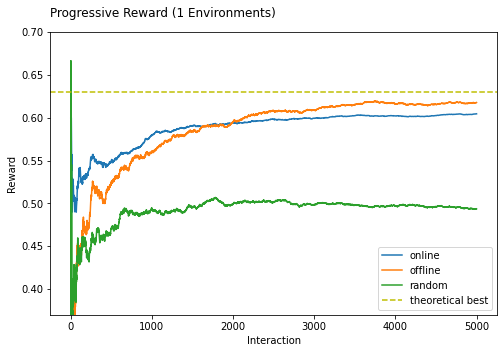

In [7]:
import coba as cb
import numpy as np
import matplotlib.pyplot as plt

from coba.primitives.rewards import SequenceReward
from coba.environments.banditreplay import BanditReplay

class CustomEnvironment:

    def __init__(self, n_interactions):
        self._n_interactions = n_interactions

    def read(self):
        rng = cb. CobaRandom(1) #so the simulation is repeatable
        for _ in range(self._n_interactions):
            features = rng.randoms(3)
            context  = dict(zip(['feature_1','feature_2','feature_3'],features))
            rewards  = SequenceReward(np.random.binomial(1, np.clip([features[0]-.5*features[1]+.25, .5],0,1)).tolist())
            yield { 'context': context, "actions": [0,1], "rewards": rewards}

online_learners     = cb.VowpalSoftmaxLearner(features=[1, 'x', 'a', 'ax', 'axx'])
online_environments = cb.Environments(CustomEnvironment(5000)).shuffle(n=5)
online_logged       = cb.SimpleEvaluation(record=['context','actions','rewards','action','reward','probability','ope_loss'])
online_result       = cb.Experiment(online_environments, online_learners, evaluation_task=online_logged).run(quiet=True)

offline_learners     = [cb.VowpalOffPolicyLearner([1, 'x', 'a', 'ax', 'axx']), cb.RandomLearner()]
offline_environments = BanditReplay(online_result.interactions.to_pandas(),take=5000)
offline_result       = cb.Experiment(offline_environments, offline_learners, evaluation_task=online_logged).run(quiet=True)

plt.figure(figsize=(8,8))
online_result.plot_learners(labels=['online'],colors=[0],out=None)
offline_result.plot_learners(labels=['offline','random'],colors=[1],out=None)
plt.axhline(y = 0.63, color = 'y', linestyle = '--', label='theoretical best')
plt.legend()
plt.ylim(.37,.7)
plt.show()

In [11]:
offline_result.__class__ = CustomResult
offline_result.eval_metrics()


,learners,reward,probability,ope_loss,environment_variance
learner_id,,,,,
0,vw: --cb_adf --random_seed 1 --interactions a...,0.6094,0.9998,-0.301671,NaN
1,random: N/A,0.4966,0.5000,0.000000,NaN


In [12]:
online_result.__class__ = CustomResult
online_result.eval_metrics()

,learners,reward,probability,ope_loss,environment_variance
learner_id,,,,,
0,vw: --cb_explore_adf --softmax --lambda 10 --r...,0.58956,0.804522,-0.058131,0.000068
